# Barlow Twins

Minimalist implemantation of Barlow Twins training procedure. Resnet models will be used in this notebook, as modeling is not the main takeaway of the paper. The goal is to test this self-supervised technique as a pretraining step for models. 

The dataset used will be a subset of the Intel Scene Classification Challenge to keep it simple and colab-friendly. 

The same model will be tested under different training schemes:


1.   Trained from scratch the data.
2.   Pre-trained on imagenet and fine-tuned.
3.   Self-supervised using barlow twins method + fine-tuning.
3.   Self-supervised using barlow twins method from model pretrained on ImageNet+ fine-tuning.


## [Paper](https://arxiv.org/abs/2103.03230)


In [ ]:
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda:0


## Datasets

In [ ]:
# Commands to download and prepare scene classification data from:
# https://drive.google.com/file/d/1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT/view?usp=sharing

! gdown --id 1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT --output scene_classification.zip

! unzip -q scene_classification.zip
! rm scene_classification.zip

Downloading...
From: https://drive.google.com/uc?id=1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT
To: /content/scene_classification.zip
253MB [00:01, 155MB/s]


In [ ]:
class TwinImageFolderDataset(ImageFolder):
    def __init__(self, twin_transform=None, *args, **kwargs):
        super().__init__(transform=None, *args, **kwargs)
        self.twin_transform = twin_transform

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)

        # Apply transform twice to get two different versions of the image.
        x1 = self.twin_transform(image)
        x2 = self.twin_transform(image)

        return x1, x2, label


In [ ]:
# Review transforms for other datasets
barlow_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.RandomCrop(112),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
    ]
)

barlow_images = TwinImageFolderDataset(
    root="train_set", twin_transform=barlow_transform
)

test_transform = transforms.Compose(
    [transforms.Resize((112, 112)), transforms.ToTensor()]
)

train_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.RandomCrop(112),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ]
)

train_images = ImageFolder(
    root="train_set", transform=train_transform
)


test_images = ImageFolder(
    root="test_set", transform=test_transform
)

classes = train_images.classes
N_CLASSES = len(classes)


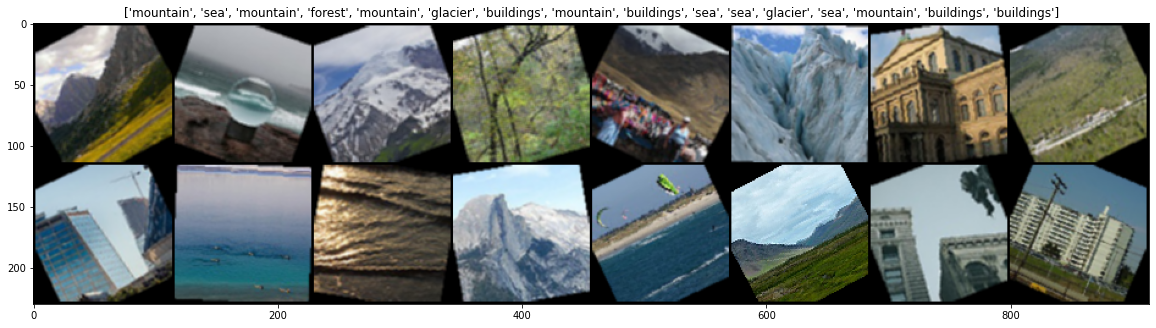

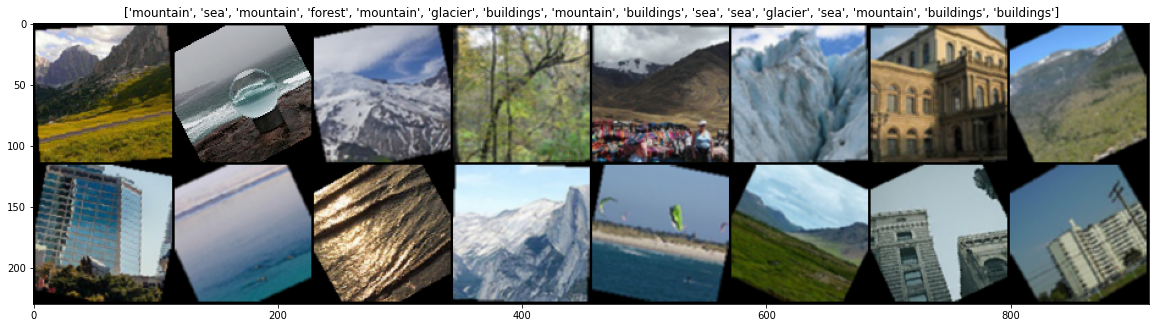

In [ ]:
# Show some image pairs
def show_image(image, title):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(title)
    plt.show()


# Get a batch of training data
example_images_loader = DataLoader(barlow_images, batch_size=16, shuffle=True)
left_images, right_images, labels = next(iter(example_images_loader))
labels = [classes[label] for label in labels]
# Increase plot size
plt.rcParams["figure.figsize"] = [20, 15]

left_grid = torchvision.utils.make_grid(left_images)
right_grid = torchvision.utils.make_grid(right_images)
show_image(left_grid, title=labels)
show_image(right_grid, title=labels)


## Model Definition

As mentioned above, model will be a ResNet18 (smallest one with available pre-trained weights) with the top cut off. Classification layers will follow the pattern described in the paper.


In [ ]:
class CustomResNetModel(nn.Module):
    """
    Custom class to make it fancier and expose two training methods.

    Parameters
    ----------
    pretrained: boolean
      Whether to use a pretrained network.
    n_classes: int
      Number of output classes fo the final classification layer.
    """

    def __init__(self, pretrained, n_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        # Making the head smaller to adapt to the problem. Paper used 8192 output units.
        self.classification_head = nn.Sequential(
            nn.Linear(in_features=512, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=n_classes),
        )

    def barlow_pretraining(self, x1, x2):
        return self.backbone(x1).squeeze(), self.backbone(x2).squeeze()

    def forward(self, x):
        features = self.backbone(x).squeeze()
        return features #self.classification_head(features)


## Training

### Barlow Pretraining functions

In [ ]:
def pretrain_epoch(model, barlow_iterator, barlow_criterion, optim):
    model.train()
    epoch_loss = 0

    for images_x1, images_x2, _ in barlow_iterator:
        optim.zero_grad()

        x1_predictions, x2_predictions = model.barlow_pretraining(
            images_x1.to(device), images_x2.to(device)
        )

        loss = barlow_criterion(x1_predictions, x2_predictions)
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(barlow_iterator)


def barlow_pretraining(
    model,
    number_epochs,
    criterion,
    optim,
    data_iterator,
    verbose=False,
):
    loss_history = []

    for epoch in tqdm(range(number_epochs), desc="Pre-Training Model", unit="epoch"):
        start_time = time.time()

        train_loss = pretrain_epoch(model, data_iterator, criterion, optim)
        loss_history.append(train_loss)
        if verbose:
            print(
                "Barlow Training epoch {} | Loss {:.6f} | Time {:.2f} seconds".format(
                    epoch + 1, train_loss, time.time() - start_time
                )
            )
    return loss_history


### Standard Training Functions

In [ ]:
def train_epoch(model, loader, criterion, optim):
    model.train()
    epoch_loss = 0

    all_labels = []
    all_predictions = []
    for images, labels in loader:
        all_labels.extend(labels.numpy())

        optim.zero_grad()

        predictions = model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        labels = labels.long()
        loss = criterion(predictions, labels.to(device))

        loss.backward()
        optim.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            predictions = model(images.to(device))
            labels = labels.long()
            loss = criterion(predictions, labels.to(device))

            val_loss += loss.item()

            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.topk(1, dim=1)[1].cpu().numpy().tolist())
    accuracy = accuracy_score(all_targets, all_predictions)

    return val_loss / len(loader), accuracy * 100


def train_model(
    model,
    number_epochs,
    criterion,
    optim,
    train_iterator,
    valid_iterator,
    verbose=False,
):
    # Stats trackers
    train_history = []
    valid_history = []
    accuracy_history = []

    for epoch in tqdm(range(number_epochs), desc="Training Model", unit="epoch"):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_iterator, criterion, optim)
        train_history.append(train_loss)
        if verbose:
            print(
                "Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                    epoch + 1, train_loss, train_acc, time.time() - start_time
                )
            )
        start_time = time.time()
        val_loss, acc = validation_epoch(model, valid_iterator, criterion)
        valid_history.append(val_loss)
        accuracy_history.append(acc)
        if verbose:
            print(
                "Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                    epoch + 1, val_loss, acc, time.time() - start_time
                )
            )
    return train_history, valid_history, accuracy_history


## Results

In [ ]:
N_EPOCHS = 25
BATCH_SIZE = 32

# Set plot size
plt.rcParams["figure.figsize"] = (20, 5)

### Training from scratch

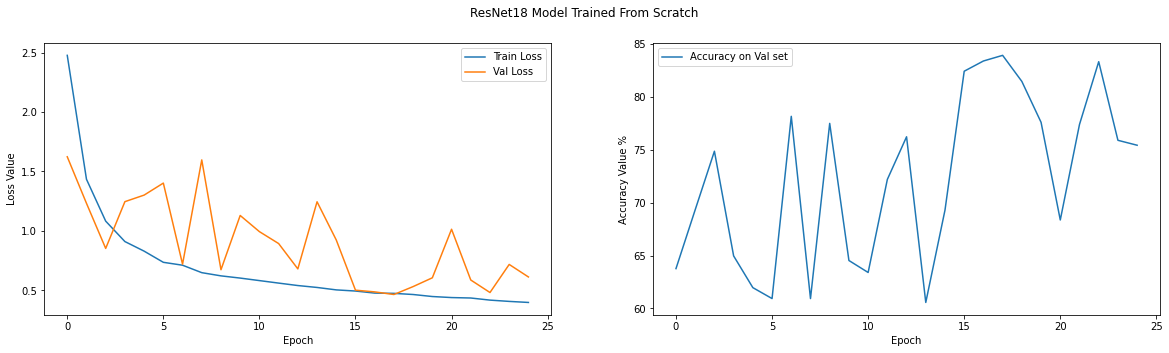

In [ ]:
scratch_model = CustomResNetModel(pretrained=False, n_classes=N_CLASSES).to(device)

train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True
)

loss = nn.CrossEntropyLoss().to(device)
model_optimizer = torch.optim.Adam(scratch_model.parameters(), lr=0.001)

train_losses, valid_losses, accuracies = train_model(
    scratch_model, N_EPOCHS, loss, model_optimizer, train_loader, test_loader
)

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("ResNet18 Model Trained From Scratch")

x = range(len(train_losses))
ax1.plot(x, train_losses, label="Train Loss")
ax1.plot(x, valid_losses, label="Val Loss")
ax1.set_ylabel("Loss Value")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(x, accuracies, label="Accuracy on Val set")
ax2.set_ylabel("Accuracy Value %")
ax2.set_xlabel("Epoch")
ax2.legend()

plt.show()


### Fine Tuning from ImageNet

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


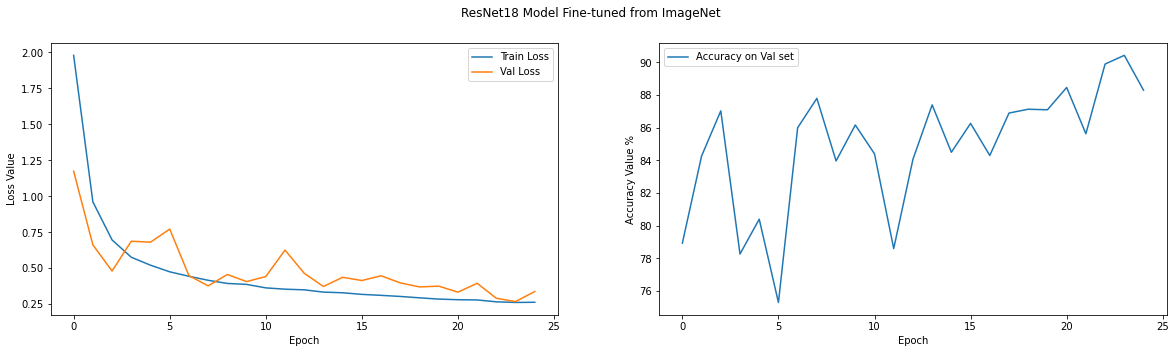

In [ ]:
imagenet_model = CustomResNetModel(pretrained=True, n_classes=N_CLASSES).to(device)

train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True
)

loss = nn.CrossEntropyLoss().to(device)
model_optimizer = torch.optim.Adam(imagenet_model.parameters(), lr=0.001)

train_losses, valid_losses, accuracies = train_model(
    imagenet_model, N_EPOCHS, loss, model_optimizer, train_loader, test_loader
)

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("ResNet18 Model Fine-tuned from ImageNet")

x = range(len(train_losses))
ax1.plot(x, train_losses, label="Train Loss")
ax1.plot(x, valid_losses, label="Val Loss")
ax1.set_ylabel("Loss Value")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(x, accuracies, label="Accuracy on Val set")
ax2.set_ylabel("Accuracy Value %")
ax2.set_xlabel("Epoch")
ax2.legend()

plt.show()


### Barlow Pretraining and Fine Tuning

In [ ]:
class BarlowTwinsCostFunction(nn.Module):
    def __init__(self, lam):
        super().__init__()
        self.lam = lam

    def forward(self, x1, x2):
        batch_size, dimension = x1.shape[:2]

        x1_norm = (x1 - x1.mean(0)) / x1.std(0)
        x2_norm = (x2 - x2.mean(0)) / x2.std(0)

        cross_corr = torch.mm(x1_norm.T, x2_norm) / batch_size

        c_diff = (cross_corr - torch.eye(dimension, device=cross_corr.device)).pow(2)

        diag_elems = torch.diagonal(c_diff)
        off_diag_elems = c_diff.masked_select(
            ~torch.eye(dimension, dtype=bool, device=c_diff.device)
        ).flatten()

        cost = diag_elems.sum() + self.lam * off_diag_elems.sum()

        return cost


In [ ]:
barlow_model = CustomResNetModel(pretrained=False, n_classes=N_CLASSES).to(device)

barlow_train_loader = DataLoader(
    barlow_images, batch_size=4*BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

loss = BarlowTwinsCostFunction(lam=0.005).to(device)
model_optimizer = torch.optim.Adam(barlow_model.parameters(), lr=0.0001)

# First Pre-Train using Barlow Twins Method
barlow_losses = barlow_pretraining(
    barlow_model, N_EPOCHS, loss, model_optimizer, barlow_train_loader
)

# Then fine tune network to get results
train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True
)

loss = nn.CrossEntropyLoss().to(device)
model_optimizer = torch.optim.Adam(barlow_model.parameters(), lr=0.0003)

train_losses, valid_losses, accuracies = train_model(
    barlow_model, N_EPOCHS, loss, model_optimizer, train_loader, test_loader
)


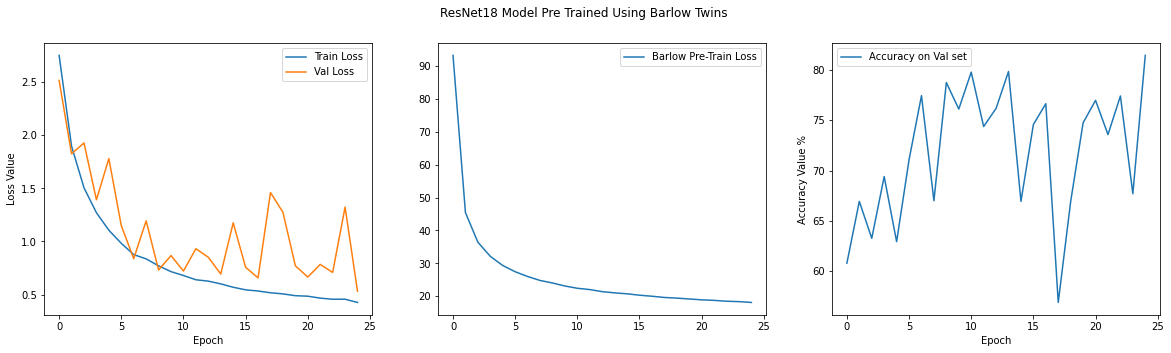

In [ ]:
# Plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("ResNet18 Model Pre Trained Using Barlow Twins")

x = range(len(train_losses))
ax1.plot(x, train_losses, label="Train Loss")
ax1.plot(x, valid_losses, label="Val Loss")
ax1.set_ylabel("Loss Value")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(range(len(barlow_losses)), barlow_losses, label="Barlow Pre-Train Loss")
ax2.legend()

ax3.plot(x, accuracies, label="Accuracy on Val set")
ax3.set_ylabel("Accuracy Value %")
ax3.set_xlabel("Epoch")
ax3.legend()

plt.show()

### Barlow Pretrainig from ImageNet Weights

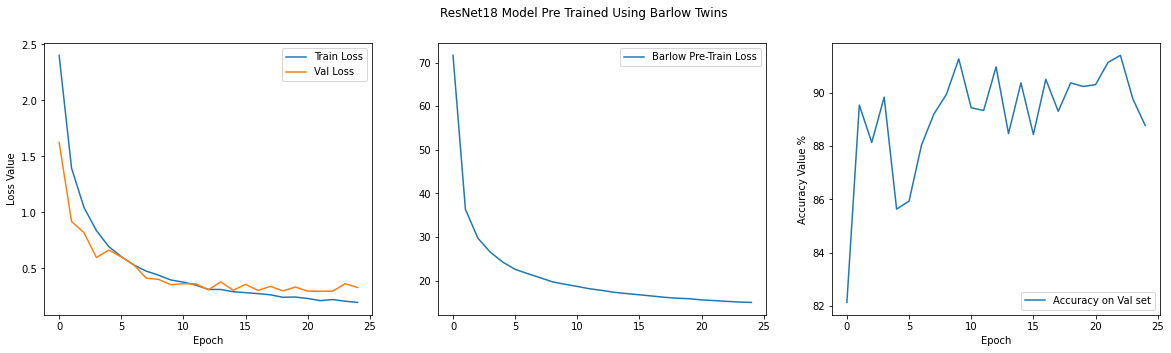

In [ ]:
barlow_model = CustomResNetModel(pretrained=True, n_classes=N_CLASSES).to(device)

barlow_train_loader = DataLoader(
    barlow_images, batch_size=4*BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

loss = BarlowTwinsCostFunction(lam=0.005).to(device)
model_optimizer = torch.optim.Adam(barlow_model.parameters(), lr=0.0001)

# First Pre-Train using Barlow Twins Method
barlow_losses = barlow_pretraining(
    barlow_model, N_EPOCHS, loss, model_optimizer, barlow_train_loader
)

# Then fine tune network to get results
train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True
)

loss = nn.CrossEntropyLoss().to(device)
model_optimizer = torch.optim.Adam(barlow_model.parameters(), lr=0.0003)

train_losses, valid_losses, accuracies = train_model(
    barlow_model, N_EPOCHS, loss, model_optimizer, train_loader, test_loader
)

# Plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("ResNet18 Model Pre Trained Using Barlow Twins")

x = range(len(train_losses))
ax1.plot(x, train_losses, label="Train Loss")
ax1.plot(x, valid_losses, label="Val Loss")
ax1.set_ylabel("Loss Value")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(range(len(barlow_losses)), barlow_losses, label="Barlow Pre-Train Loss")
ax2.legend()

ax3.plot(x, accuracies, label="Accuracy on Val set")
ax3.set_ylabel("Accuracy Value %")
ax3.set_xlabel("Epoch")
ax3.legend()

plt.show()
